Let's assume that you have a marketing campaign for which we spend **1000USD for acquiring one potential customer.** For each customer that we target with our ad campaign **and that clicks on the ad, we get an overall profit of 100USD.** However, if we target **a customer that ends up not clicking** on the ad, we incur a **net loss of 1000USD.** Therefore, we can conclude that for each **customer that was not targeted by the campaign** and who **clicks on the ad**, we get an **overall profit of 1100USD.**


**Below is how I approached this problem**

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer, fbeta_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV


df_adv = pd.read_csv('advertising.csv')
pd.options.display.max_columns = None

# defining features used
categorical_vars = ["Ad Topic Line", "City", "Country"]
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Male", "log_age"]
datetime_vars = "Timestamp"
target = "Clicked on Ad"

In [2]:
df_adv.info()
print()
print(df_adv.isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1018 non-null   float64
 1   Age                       1018 non-null   int64  
 2   Area Income               1018 non-null   float64
 3   Daily Internet Usage      1018 non-null   float64
 4   Ad Topic Line             1018 non-null   object 
 5   City                      1018 non-null   object 
 6   Male                      1018 non-null   int64  
 7   Country                   1018 non-null   object 
 8   Timestamp                 1018 non-null   object 
 9   Clicked on Ad             1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB

Daily Time Spent on Site    False
Age                         False
Area Income                 False
Daily Internet Usage        False
Ad Topic Line               False

In [3]:
# Imputing null values in target column would introduce bias into our prediction. removing those observations
df_adv = df_adv.dropna(axis=0)

In [4]:
# checking for duplicates
print('Number of duplicates:', df_adv.duplicated().sum())

Number of duplicates: 7


In [5]:
# removing duplicated observations from data
df = df_adv.drop_duplicates()

In [6]:
# Looking at target distribution
# the click rate is unusually balanced. 
# No need to adjust for class imbalances
click_rate = df_adv['Clicked on Ad'].value_counts() / df_adv.shape[0]


In [7]:
# converting Timestamp column to datetime 
df_adv['Timestamp'] = pd.to_datetime(df_adv['Timestamp'])
df_adv.dtypes

Daily Time Spent on Site           float64
Age                                  int64
Area Income                        float64
Daily Internet Usage               float64
Ad Topic Line                       object
City                                object
Male                                 int64
Country                             object
Timestamp                   datetime64[ns]
Clicked on Ad                      float64
dtype: object

In [8]:
# age has strange minimums and max values. will have to replace all outlying numbers with median/mean of age data
df_adv.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,65.043481,36.915187,54928.970631,179.372682,0.480276,0.500986
std,15.862481,31.625753,13431.891417,44.462916,0.499857,0.500246
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,0.000000
25%,51.410000,29.000000,46939.300000,138.527500,0.000000,0.000000
50%,68.215000,35.000000,57012.300000,182.650000,0.000000,1.000000
75%,78.577500,42.000000,65267.402500,218.207500,1.000000,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,1.000000


In [9]:
# lloking for observations that have unrealistic age
df_adv[df_adv['Age'] > 60]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
495,50.60,999,34191.13,129.88,Realigned reciprocal framework,New Daniellefort,1,United States of America,2016-05-03 12:57:00,1.0
604,57.20,103,57739.03,110.66,Innovative maximized groupware,East Heatherside,0,New Zealand,2016-03-19 11:09:00,1.0
684,66.08,61,58966.22,184.23,Synchronized multi-tasking ability,Klineside,1,Cuba,2016-01-07 23:02:00,1.0


In [10]:
# if we're going to be targeting a group, we should consider only targeting legal adults.
# looking for unrealistic ages under 18
df_adv[df_adv['Age'] < 18]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
294,56.01,-25,46339.25,127.26,Re-engineered real-time success,Garciamouth,0,Tonga,2016-07-05 18:59:00,1.0
823,43.16,8,25371.52,156.11,Implemented didactic support,Williamsport,1,Marshall Islands,2016-07-06 03:40:00,1.0


In [11]:
# filtering out extreme age values
df_adv = df_adv[(df_adv['Age'] < 100) & (df_adv['Age'] >= 18)]

In [12]:
# comparing the daily time spent on site to the overall daily internet usage
# looks like there are three observations where time spent on the site exceeds overall internet usage. Dropping rows
sum(df_adv['Daily Time Spent on Site'] >= df_adv['Daily Internet Usage'])

3

In [13]:
df_adv = df_adv[(df_adv['Daily Time Spent on Site']) < (df_adv['Daily Internet Usage'])]
df_adv.shape

(1007, 10)

## Data Visualization

In [14]:
# functions being used for data visualization

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data)
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])
        
def cross_correlation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)

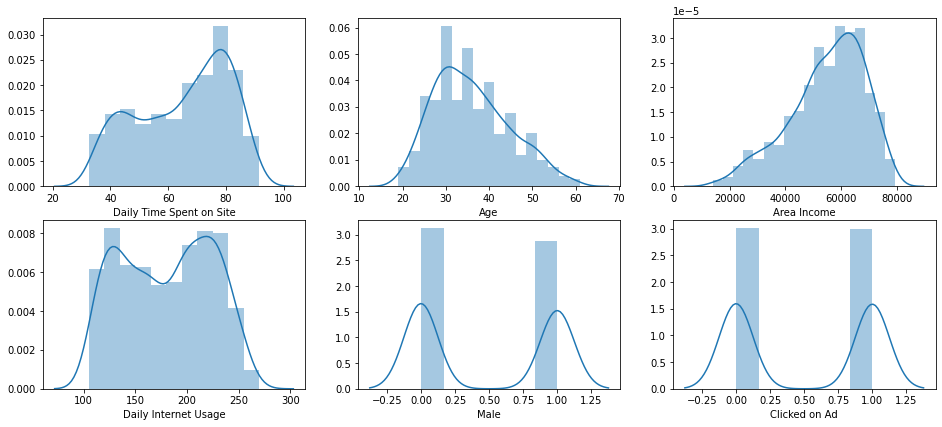

In [15]:
num_vars = df_adv.select_dtypes(exclude=['object', 'datetime64']).columns

# Creating distribution plots
creating_distplot((16,18), df_adv, num_vars);
creating_distplot;

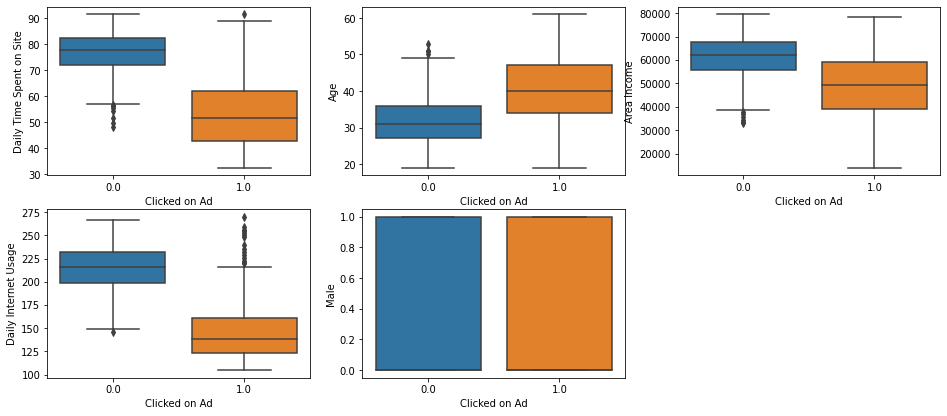

In [16]:
# Generating boxplots with respect to our target feature
creating_boxplots((16,18), target, num_vars, df_adv)

"Daily time spent on site" and "Daily internet usage" show visible differences between those who click on the ad and those who didn't. It looks like these differences are also visible with  with age and area income respectively.

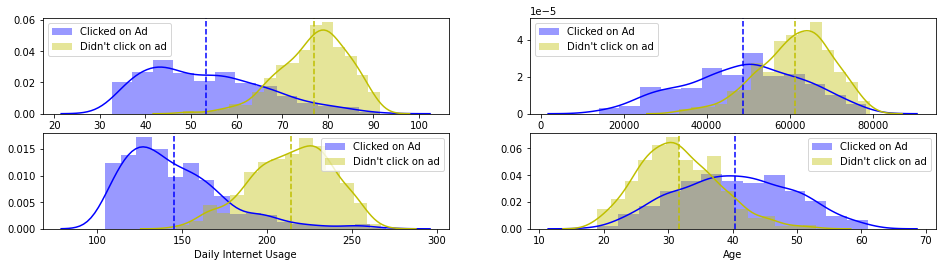

In [17]:
# Subsetting by 'got a TV'!
clicked_df = df_adv["Clicked on Ad"] == 1
no_clicked_df = df_adv["Clicked on Ad"] == 0

# Creating the plots
features = ['Daily Time Spent on Site', 'Area Income', 'Daily Internet Usage',  'Age']
labels = ['Clicked on Ad', "Didn't click on ad"]

def creating_plots(features, labels):
    plt.figure(figsize=(16,6))
    for feature in features:
        plt.subplot(3, 2, features.index(feature)+1)
        sns.distplot(df_adv[feature][clicked_df], label=labels[0], color="b")
        sns.distplot(df_adv[feature][no_clicked_df], label=labels[1], color="y")
        plt.axvline(df_adv[feature][clicked_df].mean(), linestyle = '--', color="b")
        plt.axvline(df_adv[feature][no_clicked_df].mean(), linestyle = '--', color="y")
        plt.legend()

creating_plots(features, labels)

It looks like we've got some bimodal distributions with his data. This is good because it's fleshing out for us that we're dealing with two increasingly distinct groups of people

                          Daily Time Spent on Site       Age  Area Income  \
Daily Time Spent on Site                  1.000000 -0.333213     0.312439   
Age                                      -0.333213  1.000000    -0.183048   
Area Income                               0.312439 -0.183048     1.000000   
Daily Internet Usage                      0.518204 -0.366986     0.337448   
Male                                     -0.021938 -0.018273     0.000324   
Clicked on Ad                            -0.748253  0.493562    -0.474853   

                          Daily Internet Usage      Male  Clicked on Ad  
Daily Time Spent on Site              0.518204 -0.021938      -0.748253  
Age                                  -0.366986 -0.018273       0.493562  
Area Income                           0.337448  0.000324      -0.474853  
Daily Internet Usage                  1.000000  0.028608      -0.786165  
Male                                  0.028608  1.000000      -0.036904  
Clicked on Ad   

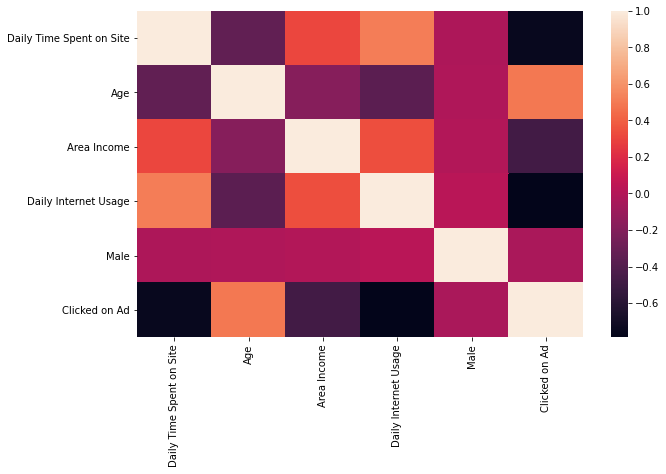

In [18]:
cross_correlation(df_adv)

In [19]:
# Engineering new datetime features
# splitting timestamp by month, day, and hour
# splitting by year is not necessary because all data was from 2016

def convert_to_int(df_column):
    boolean_list = []
    for i in df_column:
        boolean_list.append(int(i))
    df_column = boolean_list
    return df_column

df_adv['timestamp_month'] = df_adv['Timestamp'].dt.month
df_adv['timestamp_day_of_month'] = df_adv['Timestamp'].dt.day
df_adv['timestamp_hour'] = df_adv['Timestamp'].dt.hour

# further binning timestamp_hour into morning, afternoon, and evening
df_adv['timestamp_is_morning'] = (df_adv['timestamp_hour'] < 12) & (df_adv['timestamp_hour'] >= 6)
df_adv['timestamp_is_afternoon'] = (df_adv['timestamp_hour'] >= 12) & (df_adv['timestamp_hour'] < 19)
df_adv['timestamp_is_night'] = (df_adv['timestamp_hour'] >= 19) | (df_adv['timestamp_hour'] < 6) | (df_adv['timestamp_hour'] == 0)

# creating weekend/weekday timestamp columns
df_adv['timestamp_is_weekday'] = df_adv['Timestamp'].dt.weekday < 5
df_adv['timestamp_is_weekend'] = df_adv['Timestamp'].dt.weekday > 5

# converting all booleans to ints

df_adv['timestamp_is_afternoon'] = convert_to_int(df_adv['timestamp_is_afternoon'])
df_adv['timestamp_is_morning'] = convert_to_int(df_adv['timestamp_is_morning'])
df_adv['timestamp_is_night'] = convert_to_int(df_adv['timestamp_is_night'])
df_adv['timestamp_is_weekday'] = convert_to_int(df_adv['timestamp_is_weekday'])
df_adv['timestamp_is_weekend'] = convert_to_int(df_adv['timestamp_is_weekend'])

# engineering weekday feature for readability

weekday_names = {0 :'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

weekday_list = []

for i in df_adv['Timestamp'].dt.weekday:
    weekday_list.append(weekday_names[i])

df_adv['timestamp_day_of_week'] = weekday_list


# encode timestamp_month feature
df_adv['timestamp_month'] = ['January' if x == 1
                        else 'February' if x == 2
                        else 'March' if x == 3
                        else 'April' if x == 4
                        else 'May' if x == 5
                        else 'June' if x == 6
                        else 'July'
                        for x in df_adv['timestamp_day_of_month']]


# dropping timestamp column after engineering new features
df_adv = df_adv.drop(columns='Timestamp')
df_adv.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Clicked on Ad,timestamp_month,timestamp_day_of_month,timestamp_hour,timestamp_is_morning,timestamp_is_afternoon,timestamp_is_night,timestamp_is_weekday,timestamp_is_weekend,timestamp_day_of_week
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,0.0,July,27,0,0,0,1,0,1,Sunday
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,0.0,April,4,1,0,0,1,1,0,Monday
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,0.0,July,13,20,0,0,1,0,1,Sunday
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,0.0,July,10,2,0,0,1,0,1,Sunday
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,0.0,March,3,3,0,0,1,1,0,Friday


In [20]:
# Both cities and countries are features with high cardinality. We'll consider dropping them to improve the model
print(f'total number of unique cities:', {df_adv['City'].nunique()})
print(f'total number of unique countries:', {df_adv['Country'].nunique()})

#  the countries with the highest number of observations are all below 10
df_adv['Country'].sort_values().value_counts().head()

total number of unique cities: {969}
total number of unique countries: {237}


France            9
Madagascar        9
Czech Republic    9
Greece            8
Liberia           8
Name: Country, dtype: int64

In [21]:
# checking if some countries show a perference for the ad over others
# this will likely not yield much actionable insight due to the small amount of observations per country
countries_clicked_table = pd.crosstab(df_adv["Country"],
                                    df_adv["Clicked on Ad"], rownames=['Country'],
                                    colnames=["Clicked On Ad"])

countries_clicked_table.sort_values(1, axis=0, ascending=False)

Clicked On Ad,0.0,1.0
Country,,
Australia,1,7
Turkey,1,7
Liechtenstein,0,7
Ethiopia,0,7
Liberia,2,6
...,...,...
Nicaragua,3,0
Niue,3,0
Panama,2,0


This is where we'll stop looking at the country column as a means of extracting valuable information. The max possible users for any country is only 9

mean:  4.248945147679325
standard deviation:  col_0
count    1.875706
dtype: float64


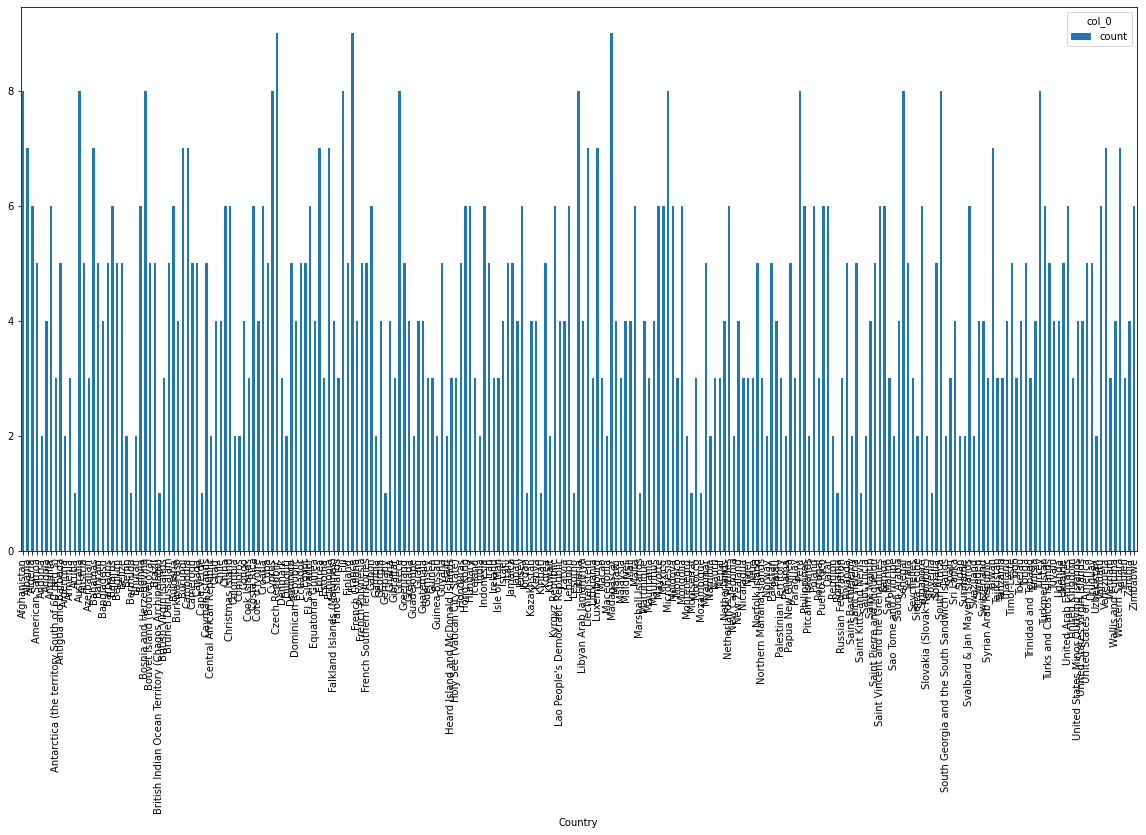

In [22]:
# this distribution we're seeing is not useful for analysis because of all 237 countries
all_countries_table = pd.crosstab(index=df_adv['Country'], columns='count')
all_countries_table.plot.bar(figsize=(20,10))
print('mean: ', np.mean(all_countries_table['count']))
print('standard deviation: ', all_countries_table.std())

In [23]:
# dropping both countries and cities columns
# dropping Ad Topic Line as well. We could have used natural language processing techniques here
# but for the sake of simplicity, we'll drop this column as well

df_adv = df_adv.drop(['Ad Topic Line', 'City', 'Country'], axis=1)

# Final feature engineering touches

Lastly, we also had a few features that were skewing. In order to combat this, we'll log transform the age column (which was right skewed), and the area income model, which was left skewed. This will hopefully squash the effect of outliers. 

We'll also normalize all numerical features with a scaler object

In [24]:
# log transforming skewed data

df_adv['log_age'] = np.log(df_adv['Age'])
df_adv['log_income'] = np.log(df_adv['Area Income'])

In [25]:
# normalizing all numerical data

# Defining categorical, numerical, and datetime variables that we will use later
categorical_vars = ["Ad Topic Line", "City", "Country"]
numerical_vars = ["Daily Time Spent on Site", "Area Income", "Daily Internet Usage", "Male", "log_age",
                  'timestamp_day_of_month', 'timestamp_hour', 'timestamp_is_morning', 'timestamp_is_afternoon',
                 'timestamp_is_night','timestamp_is_weekday','timestamp_is_weekend']
datetime_vars = "Timestamp"
target = "Clicked on Ad"

# instantiating scaler object
scaler = MinMaxScaler()

# MinMax scaling to all numerical features
data = pd.DataFrame(data=df_adv)
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])

data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,timestamp_month,timestamp_day_of_month,timestamp_hour,timestamp_is_morning,timestamp_is_afternoon,timestamp_is_night,timestamp_is_weekday,timestamp_is_weekend,timestamp_day_of_week,log_age,log_income
0,0.617882,35,0.730472,0.916031,0.0,0.0,July,0.866667,0.000000,0.0,0.0,1.0,0.0,1.0,Sunday,0.523740,11.032207
1,0.809621,31,0.831375,0.538746,1.0,0.0,April,0.100000,0.043478,0.0,0.0,1.0,1.0,0.0,Monday,0.419696,11.133740
2,0.626721,26,0.699200,0.797433,0.0,0.0,July,0.400000,0.869565,0.0,0.0,1.0,0.0,1.0,Sunday,0.268903,10.998526
3,0.706272,29,0.623160,0.854280,1.0,0.0,July,0.300000,0.086957,0.0,0.0,1.0,0.0,1.0,Sunday,0.362521,10.911558
4,0.608023,35,0.914568,0.731323,0.0,0.0,March,0.066667,0.130435,0.0,0.0,1.0,1.0,0.0,Friday,0.523740,11.210333
